In [2]:
import xarray as xr
import numpy as np 
import os
import types
import matplotlib.pyplot as plt
import pandas as pd
import gc

from src.utils import util_cesm
from src import config_cesm
from src.models import models_util
from src.models import models 

reference_grid = util_cesm.generate_sps_grid()

def load_globals(module):
    """
    Load all global variables declared in a module as a dictionary.
    
    Parameters:
        module (module): The loaded Python module.
    
    Returns:
        dict: A dictionary containing global variables from the module.
    """
    return {
        name: value
        for name, value in vars(module).items()
        if not name.startswith("__") and not isinstance(value, types.ModuleType) and not callable(value)
    }

def get_ensemble_members_and_time_coords(data_split_settings, split):
    if data_split_settings["split_by"] == "ensemble_member":
        ensemble_members = data_split_settings[split]
        time_coords = data_split_settings["time_range"]
    elif data_split_settings["split_by"] == "time":
        ensemble_members = data_split_settings["member_ids"]
        time_coords = data_split_settings[split]

    return ensemble_members, time_coords


def broadcast_climatology_like(data_split_settings, da):
    """
    Param:
        dict            this should have the name of the data_settings which specifies the climatology 
        xr.DataArray    prediction-like array that you want to broadcast climatology 
    
    Returns:
        xr.DataArray    climatology broadcasted
    """

    icefrac_mean = xr.open_dataset(f"{config_cesm.PROCESSED_DATA_DIRECTORY}/normalized_inputs/{data_split_settings["name"]}/icefrac_mean.nc").icefrac
    
    def calculate_month(start_month, lead_time):
        return (start_month + lead_time - 2) % 12 + 1

    pred_months = xr.apply_ufunc(
        calculate_month,
        da["start_prediction_month"].dt.month,
        da["lead_time"],
        vectorize=True,
        dask="allowed",
        output_dtypes=[int],
    )

    climatology_broadcasted = icefrac_mean.sel(month=pred_months).broadcast_like(da).drop_vars("month")

    return climatology_broadcasted


def add_climatology(da, climatology_broadcasted, clip=True):
    """
    Param:
        (xr.DataArray)  array of anomalies
        (xr.DataArray)  array of climatology that is the same shape as da
                        note: to do this you can run broadcast_climatology_like
        (bool)          possibly clip the anomalies to 

    Returns:
        (xr.DataArray)
    """
    # Add climatology back to the anomalies
    absolute_da = da + climatology_broadcasted

    # Clip the resulting values to [0, 1]
    if clip: absolute_da = absolute_da.clip(0, 1)

    return absolute_da

def remove_climatology(da, climatology_broadcasted):
    return da - climatology_broadcasted


def load_model_predictions(config, nn_ens_avg=True, climatology_broadcasted=None, add_climatology_to_anomaly=True):
    """
    If the config specifies that the predictions are anomalies, then the climatology is added back
    WITH clipping of unphysical values (e.g., if anomaly prediction is -0.5 but the climatology for that
    cell is 0.3, then the resulting value will be clipped to 0).
    """
    output_dir = os.path.join(config_cesm.PREDICTIONS_DIRECTORY, config["EXPERIMENT_NAME"])
    output_path = os.path.join(output_dir, f"{config["MODEL"]}_{config["CHECKPOINT_TO_EVALUATE"]}_predictions.nc")
    predictions = xr.open_dataset(output_path).predictions 

    if config["TARGET_CONFIG"]["predict_anom"] and add_climatology_to_anomaly:
        if climatology_broadcasted is None:
            raise ValueError("need to supply climatology_broadcasted if add_climatology_to_anomaly is true!")

        predictions = add_climatology(predictions, climatology_broadcasted)

    if nn_ens_avg and ("nn_member_id" in predictions.dims): 
        predictions = predictions.mean("nn_member_id")

    return predictions 

def load_targets(config, split, climatology_broadcasted=None, add_climatology_to_anomaly=True):
    ensemble_members, time_coords = get_ensemble_members_and_time_coords(config["DATA_SPLIT_SETTINGS"], split)
    data_dir = os.path.join(config_cesm.PROCESSED_DATA_DIRECTORY, "data_pairs", config["DATA_SPLIT_SETTINGS"]["name"])
    ds_list = []
    for member_id in ensemble_members:
        ds = xr.open_dataset(os.path.join(data_dir, f"targets_member_{member_id}.nc")).data.load()
        ds_list.append(ds)

    targets = xr.concat(ds_list, dim="member_id").sel(start_prediction_month=time_coords)
    targets = targets.transpose("start_prediction_month", "member_id", "lead_time", "y", "x")

    if config["TARGET_CONFIG"]["predict_anom"] and add_climatology_to_anomaly:
        if climatology_broadcasted is None:
            raise ValueError("need to supply climatology_broadcasted if add_climatology_to_anomaly is true!")

        targets = add_climatology(targets, climatology_broadcasted)

    return targets

def get_broadcast_climatology(config, split):
    ensemble_members, time_coords = get_ensemble_members_and_time_coords(config["DATA_SPLIT_SETTINGS"], split)

    empty_predictions_da = models_util.generate_empty_predictions_ds(reference_grid, 
            time_coords, 
            ensemble_members,
            config["MAX_LEAD_MONTHS"], 80, 80).predictions 
    
    return broadcast_climatology_like(config["DATA_SPLIT_SETTINGS"], empty_predictions_da)

def calculate_integrated_area_error(predictions, targets):
    integrated_area_error = xr.DataArray(
        np.empty((config.MAX_LEAD_MONTHS,12)),
        dims = ("lead_time", "month")
    )

    for lead in range(config.MAX_LEAD_MONTHS):
        diff = np.abs(targets.isel(lead_time=lead) - predictions.isel(lead_time=lead))

        area_error = (diff * reference_grid.area).sum(("x","y"))

        avg_error = area_error.groupby("start_prediction_month.month").mean(("start_prediction_month", "member_id"))
        integrated_area_error[lead,:] = np.roll(avg_error, lead)

    icefrac_mean = xr.open_dataset(f"{config_cesm.PROCESSED_DATA_DIRECTORY}/normalized_inputs/{config.DATA_CONFIG_NAME}/icefrac_mean.nc").icefrac
    for month in range(12):
        mean_sia = (icefrac_mean.isel(month=month) * reference_grid.area).sum(("x","y"))
        integrated_area_error[:, month] /= mean_sia

    return integrated_area_error

def calculate_rmse(predictions, targets):
    max_lead_months = len(predictions.lead_time)
    
    rmse_da = xr.DataArray(
        np.empty((max_lead_months, 12)),
        dims = ("lead_time", "month")
    )

    for lead in range(max_lead_months):
        squared_residuals = (targets.isel(lead_time=lead) - predictions.isel(lead_time=lead)) ** 2

        mse = squared_residuals.groupby("start_prediction_month.month").mean(("start_prediction_month", "member_id", "x", "y"))
        rmse = np.sqrt(mse)

        rmse_da[lead, :] = np.roll(rmse, lead) 
        
    return rmse_da

def calculate_acc(pred_anom, truth_anom, aggregate, dim="start_prediction_month"):
    """
    Calculate the Anomaly Correlation Coefficient (ACC) between predictions and truth.

    Parameters:
    - pred_anom  (xr.DataArray): Predictions (absolute, not anomalies) 
    - truth_anom (xr.DataArray): True anomalies with dimensions including `dim`.
    - aggregate          (bool): if True, mean-aggregate down to dims (month, lead_time) 
    - dim                 (str): The dimension over which to calculate the ACC.
                                 Default is "start_prediction_month".
    
    Returns:
    - xr.DataArray: ACC values with dimensions remaining after collapsing `dim`.
    """
    # Ensure dimensions match
    if pred_anom.dims != truth_anom.dims:
        raise ValueError("Predictions and truth must have the same dimensions.")

    acc = xr.cov(pred_anom, truth_anom, dim=dim) / (pred_anom.std(dim=dim) * truth_anom.std(dim=dim))

    if aggregate:
        if dim == ("x", "y"):
            acc = acc.mean('member_id').groupby("start_prediction_month.month").mean("start_prediction_month")
            
        # roll in lead time so that it gets lined up
        acc = xr.concat(
            [acc.roll(month=int(lt - 1), roll_coords=False).sel(lead_time=lt) for lt in acc.lead_time.values],
            dim="lead_time"
        )

    return acc

class ModelDiagnostics():
    """
    This wrapper class is used to evaluate the model predictions for a given experiment configuration.
    """

    def __init__(self, config, nn_ens_avg, climatology_broadcasted: xr.DataArray = None):
        """
        Expected: 
            config (dict)       dictionary of the experiment configuration 
            nn_ens_avg (bool)   if the predictions include multiple neural net ensemble members, 
                                this averages the predictions if set to true. 

        Optional:
            climatology_broadcasted (xr.DataArray)  climatology broadcasted to the same shape \
                as the model predictions. If not provided, then it will be loaded according to \
                config. Note that this can take a long time, so if possible it is preferable \
                to supply the climatology_broadcasted array.
        """

        self.config = config
        self.nn_ens_avg = nn_ens_avg 

        # load climatology if not provided
        if climatology_broadcasted is None:
            self.climatology_broadcasted = get_broadcast_climatology(config, "test")
        else:
            self.climatology_broadcasted = climatology_broadcasted

        # load predictions and targets into xr.DataArray 
        self.predictions = self.load_model_predictions_wrapper()
        self.predictions_anomaly = remove_climatology(self.predictions, self.climatology_broadcasted)

        self.targets = self.load_targets_wrapper()
        self.targets_anomaly = remove_climatology(self.targets, self.climatology_broadcasted)

        # calculate linear difference
        self.diff = self.predictions - self.targets
        
    def load_model_predictions_wrapper(self):
        return load_model_predictions(self.config, self.nn_ens_avg, climatology_broadcasted=self.climatology_broadcasted) 

    def load_targets_wrapper(self):
        return load_targets(self.config, "test", climatology_broadcasted=self.climatology_broadcasted)

    def calculate_acc(self, aggregate, dim):
        return calculate_acc(self.predictions_anomaly, self.targets_anomaly, aggregate, dim)

In [12]:
from src.experiment_configs.exp2_data_volume import vol1 
from src.experiment_configs.exp2_data_volume import vol2
from src.experiment_configs.exp2_data_volume import vol3 
from src.experiment_configs.exp2_data_volume import vol4

names = ["vol1", "vol2", "vol3", "vol4"]

acc = {}
acc_persist = {}
acc_clim = {}
save_dir = config_cesm.ANALYSIS_RESULTS_DIRECTORY 

for i, config in enumerate([vol1, vol2, vol3, vol4]): 
    key = names[i]
    print(f"Loading broadcasted climatology for {key}")
    cdict = load_globals(config) 
    climatology_broadcast = get_broadcast_climatology(cdict, "test")

    # print(f"Loading persistence and climatology forecast...")
    # persistence_predictions = models.anomaly_persistence(config.DATA_SPLIT_SETTINGS, None).predictions
    # climatology_predictions = models.climatology_predictions(config.DATA_SPLIT_SETTINGS, None).predictions

    print("Calculating and saving acc...")
    diagnostics = ModelDiagnostics(cdict, True, climatology_broadcast) 
    
    # acc[key] = diagnostics.calculate_acc(dim=("x","y"), aggregate=True)

    # targets_anomaly = diagnostics.targets_anomaly
    # persist_anom = remove_climatology(persistence_predictions, climatology_broadcast)
    # acc_persist[key] = calculate_acc(persist_anom, targets_anomaly, dim=("x","y"), aggregate=True)

    # clim_anom = remove_climatology(climatology_predictions, climatology_broadcast)
    # acc_clim[key] = calculate_acc(clim_anom, targets_anomaly, dim=("x","y"), aggregate=True)

    # save_dir = config_cesm.ANALYSIS_RESULTS_DIRECTORY 
    # acc[key].to_netcdf(os.path.join(save_dir, f"{key}_ACC.nc"))
    # acc_persist[key].to_netcdf(os.path.join(save_dir, f"{key}_ACC_persist.nc"))
    # acc_clim[key].to_netcdf(os.path.join(save_dir, f"{key}_ACC_clim.nc"))

    print("Calculating SIA anomaly...") 
    # sia_anomaly = (diagnostics.predictions_anomaly  * reference_grid.area).sum(("x","y")) / 1e12
    sia_anomaly_truth = (diagnostics.targets_anomaly  * reference_grid.area).sum(("x","y")) / 1e12

    sia_anomaly_truth.to_netcdf(os.path.join(save_dir, f"{key}_SIA_anomaly_truth.nc"))

    del climatology_broadcast, diagnostics, sia_anomaly_truth 
    # del climatology_broadcast, persistence_predictions, climatology_predictions, diagnostics, \
    #     targets_anomaly, persist_anom, clim_anom, sia_anomaly
    gc.collect()


Loading broadcasted climatology for vol1
Calculating and saving acc...
Calculating SIA anomaly...
Loading broadcasted climatology for vol2
Calculating and saving acc...
Calculating SIA anomaly...
Loading broadcasted climatology for vol3
Calculating and saving acc...
Calculating SIA anomaly...
Loading broadcasted climatology for vol4
Calculating and saving acc...
Calculating SIA anomaly...


In [3]:
from src.experiment_configs.exp2_data_volume import vol1 
from src.experiment_configs.exp2_data_volume import vol2
from src.experiment_configs.exp2_data_volume import vol3 
from src.experiment_configs.exp2_data_volume import vol4

names = ["vol1", "vol2", "vol3", "vol4"]

acc = {}
sia_anomaly = {}
sia_anomaly_truth = {}
save_dir = config_cesm.ANALYSIS_RESULTS_DIRECTORY

for i, config in enumerate([vol1, vol2, vol3, vol4]): 
    key = names[i]
    acc[key] = xr.open_dataset(os.path.join(save_dir, f"{key}_ACC.nc"))["__xarray_dataarray_variable__"]
    sia_anomaly[key] = xr.open_dataset(os.path.join(save_dir, f"{key}_SIA_anomaly.nc"))["__xarray_dataarray_variable__"]
    sia_anomaly_truth[key] = xr.open_dataset(os.path.join(save_dir, f"{key}_SIA_anomaly_truth.nc"))["__xarray_dataarray_variable__"]
    

In [50]:
def plot_markers(ax, exceeds_persistence, exceeds_climatology, x_centers, y_centers):
    for i in range(6):
        for j in range(12):
            if exceeds_persistence[i,j] and exceeds_climatology[i,j]:
                ax.plot(x_centers[j], y_centers[i], 'dk', markersize=4) 
            elif exceeds_persistence[i,j]:
                ax.plot(x_centers[j], y_centers[i], '.k', markersize=4) 
            elif exceeds_climatology[i,j]:
                ax.plot(x_centers[j], y_centers[i], 'ok', markersize=4) 

/tmp/ipykernel_12275/1251899319.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


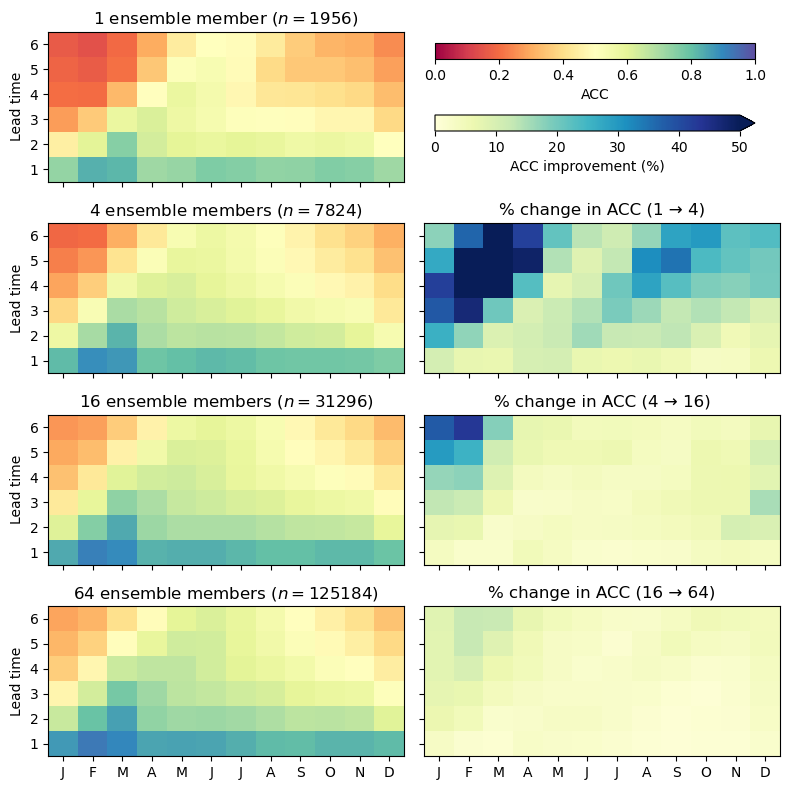

In [4]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(8, 8), sharex=True, sharey=True)

# Remove the empty top-right plot
fig.delaxes(axs[0,1])

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

vol_factor = [1, 4, 16, 64]

# Create placeholders for colorbars
cax1 = None  # main accuracy
cax2 = None  # difference

for i, key in enumerate(names):
    # Main plot
    cax = axs[i, 0].pcolormesh(x, y, acc[key], cmap='Spectral', shading='flat', vmin=0, vmax=1)
    if cax1 is None:
        cax1 = cax  # save for colorbar

    axs[i, 0].set_yticks(y_centers, labels=np.arange(1, 7, 1))
    axs[i, 0].set_ylabel("Lead time")

    # exceeds_persistence = acc[key] > acc_persist[key]
    # exceeds_clim = acc[key] > acc_clim[key]
    # plot_markers(axs[i,0 ], exceeds_persistence, exceeds_clim, x_centers, y_centers)

    if i == 0:
        axs[i, 0].set_title(rf"{vol_factor[i]} ensemble member ($n=1956$)", fontsize=12)
    else:
        axs[i, 0].set_title(rf"{vol_factor[i]} ensemble members ($n={1956 * vol_factor[i]}$)", fontsize=12)
        axs[i, 1].set_title(f"% change in ACC ({vol_factor[i-1]} → {vol_factor[i]})")
        diff_cax = axs[i, 1].pcolormesh(
            x, y, 100 * (acc[names[i]] - acc[names[i-1]]) / acc[names[i-1]],
            cmap="YlGnBu", shading="flat", vmin=0, vmax=50
        )
        if cax2 is None:
            cax2 = diff_cax 

axs[3, 0].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])

# Add colorbars in the top-right empty space
from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(axs[0, 0])

cbar_ax1 = fig.add_axes([0.55, 0.92, 0.4, 0.02]) 
cbar_ax2 = fig.add_axes([0.55, 0.83, 0.4, 0.02])

fig.colorbar(cax1, cax=cbar_ax1, orientation='horizontal', label='ACC')
fig.colorbar(cax2, cax=cbar_ax2, orientation='horizontal', label='ACC improvement (%)', extend='max')

plt.tight_layout()
plt.savefig("figures/cesm/exp2_ACC_data_volume.png", dpi=300, bbox_inches='tight')


/tmp/ipykernel_12275/2428556890.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


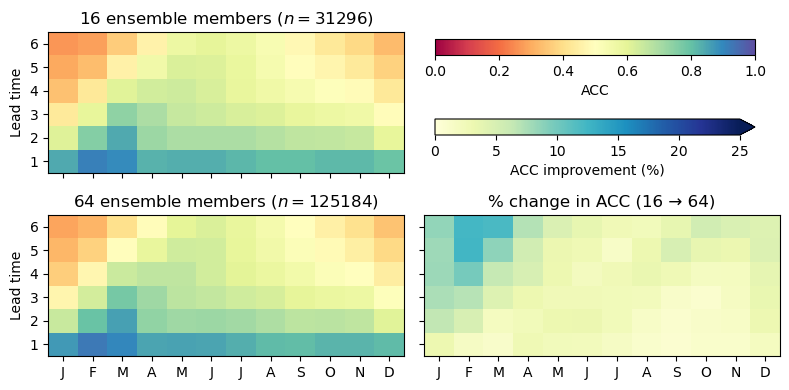

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 4), sharex=True, sharey=True)

# Remove the empty top-right plot
fig.delaxes(axs[0,1])

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

vol_factor = [1, 4, 16, 64]

# Create placeholders for colorbars
cax1 = None  # main accuracy
cax2 = None  # difference

for i, key in enumerate(names[2:4]):
    # Main plot
    cax = axs[i, 0].pcolormesh(x, y, acc[key], cmap='Spectral', shading='flat', vmin=0, vmax=1)
    if cax1 is None:
        cax1 = cax  # save for colorbar

    axs[i, 0].set_yticks(y_centers, labels=np.arange(1, 7, 1))
    axs[i, 0].set_ylabel("Lead time")

    # exceeds_persistence = acc[key] > acc_persist[key]
    # exceeds_clim = acc[key] > acc_clim[key]
    # plot_markers(axs[i,0 ], exceeds_persistence, exceeds_clim, x_centers, y_centers)

    if i == 0:
        axs[i, 0].set_title(rf"{vol_factor[i+2]} ensemble members ($n={1956 * vol_factor[i+2]}$)", fontsize=12)
    else:
        axs[i, 0].set_title(rf"{vol_factor[i+2]} ensemble members ($n={1956 * vol_factor[i+2]}$)", fontsize=12)
        axs[i, 1].set_title(f"% change in ACC ({vol_factor[i+1]} → {vol_factor[i+2]})")
        diff_cax = axs[i, 1].pcolormesh(
            x, y, 100 * (acc[names[i+2]] - acc[names[i+1]]) / acc[names[i+1]],
            cmap="YlGnBu", shading="flat", vmin=0, vmax=25
        )
        if cax2 is None:
            cax2 = diff_cax 

axs[1, 0].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])

# Add colorbars in the top-right empty space
from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(axs[0, 0])

cbar_ax1 = fig.add_axes([0.55, 0.85, 0.4, 0.04]) 
cbar_ax2 = fig.add_axes([0.55, 0.65, 0.4, 0.04])

fig.colorbar(cax1, cax=cbar_ax1, orientation='horizontal', label='ACC')
fig.colorbar(cax2, cax=cbar_ax2, orientation='horizontal', label='ACC improvement (%)', extend='max')

plt.tight_layout()
plt.savefig("figures/cesm/exp2_ACC_data_volume_3.png", dpi=300, bbox_inches='tight')


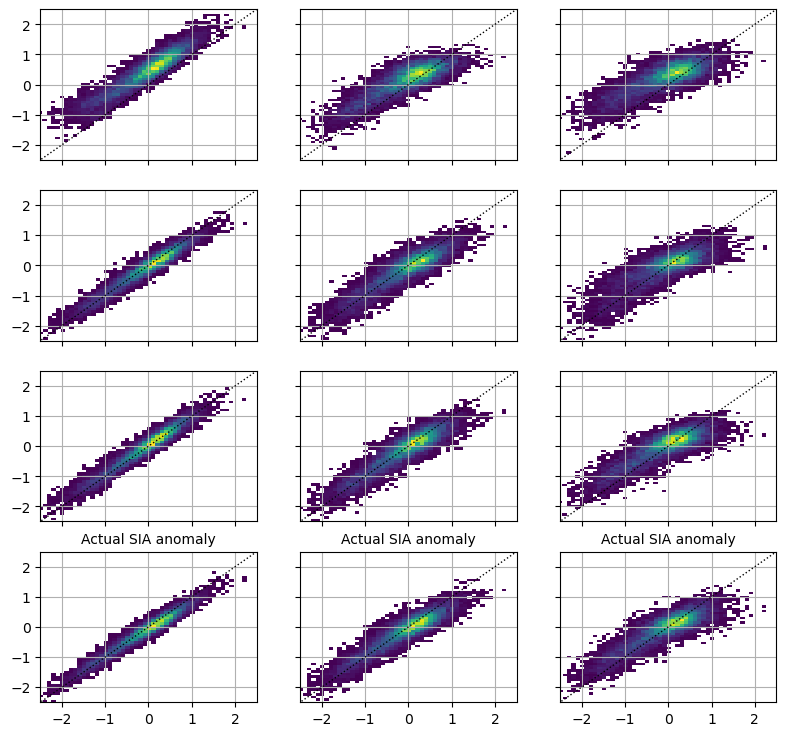

In [21]:

fix, axs = plt.subplots(figsize=(9.5,9), nrows=4, ncols=3, sharex=True, sharey=True)

lead_times = [1, 3, 6]
for i, key in enumerate(["vol1", "vol2", "vol3", "vol4"]):
    for j in range(3):
        lead = lead_times[j] - 1

        pred_to_plot = sia_anomaly[key].isel(lead_time=lead)
        truth = sia_anomaly_truth[key].isel(lead_time=lead)
        axs[i,j].hist2d(truth.to_numpy().flatten(), pred_to_plot.to_numpy().flatten(), bins=50, cmin=1)

        # plot 1 to 1 line
        axs[i,j].plot([-4,4], [-4,4], color='k', linewidth=1, linestyle='dotted')
        
        # format
        axs[i,j].grid(True)
        axs[i,j].set_ylim(-2.5, 2.5)
        axs[i,j].set_xlim(-2.5, 2.5)
        # axs[i,0].set_ylabel(f"{pred_label} SIA anomaly")
        axs[2,j].set_xlabel("Actual SIA anomaly")

        # compute R^2 
        # r = np.corrcoef(sia_anom.to_numpy().flatten(), pred_to_plot.to_numpy().flatten())
        # axs[i,j].set_title(rf"Lead {lead+1}: $R^2$ = {np.round(r[0,1] ** 2,2)}")

#plt.savefig("figures/cesm//sia_prediction_distribution.jpg", dpi=300, bbox_inches='tight')

In [40]:
sia = sia_anomaly_truth["vol1"].isel(lead_time=0)

def quadratic_detrend(da):
    t = np.arange(len(da['start_prediction_month']))
    t_centered = t - np.mean(t)

    X = np.vstack([np.ones_like(t_centered), t_centered, t_centered**2]).T
    coeffs = np.linalg.lstsq(X, da.values, rcond=None)[0]  # Shape: (3, member_id)
    trend = (X @ coeffs).reshape(da.shape)
    detrended = da - xr.DataArray(trend, dims=da.dims, coords=da.coords)

    return detrended

detrended = quadratic_detrend(sia)


autocorr_da = lagged_autocorrelation_by_month(detrended, max_lag=24)


In [56]:
for month in range(1, 13):
    for offset in range(24):
        a = detrended.where(detrended.start_prediction_month.dt.month==month, drop=True)
        b = detrended.shift(start_prediction_month=-offset)

        b = b.where(b.start_prediction_month )
        .where(detrended.start_prediction_month.dt.month==((month + offset) % 12)+1, drop=True)

In [59]:
detrended.shift(start_prediction_month=3).start_p

<xarray.DataArray (start_prediction_month: 1956, member_id: 5)> Size: 78kB
array([[        nan,         nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan],
       ...,
       [-0.30951009, -0.86686321, -0.19864169, -0.00807733, -0.16282634],
       [-0.16685411, -0.87794113, -0.3888937 , -0.00126823, -0.18518332],
       [ 0.17129761, -0.80374864, -0.21009397,  0.009093  , -0.1752457 ]])
Coordinates:
  * member_id               (member_id) <U12 240B 'r19i1301p1f2' ... 'r20i130...
    lead_time               int64 8B 1
  * start_prediction_month  (start_prediction_month) datetime64[ns] 16kB 1851...